# Unwanted Substructures

*Pan-assay interference compounds* or *PAINS* are chemical compounds that give false-positive results in high-throughput screens.
They tend to react nonspecifically with many biological targets rather than specifically affecting one desired target.
They are usually identified by their functional groups.

## 1. Load and Visualize

In [1]:
import os
import pandas as pd

data_path = os.path.join(os.getcwd(), "data")
file_path = os.path.join(data_path, "EGFR_compounds_with_ro5.csv")

compounds_df = pd.read_csv(file_path, index_col=0)
compounds_df.drop(columns=["mwt", "nhba", "nhbd", "logp"], inplace=True)
compounds_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,meets_ro5
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True


,molecule_chembl_id,IC50,units,smiles,pIC50,meets_ro5,mol
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True,
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True,
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True,
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True,
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True,

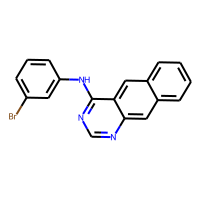
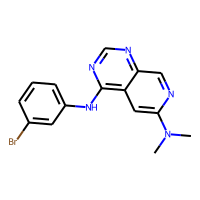
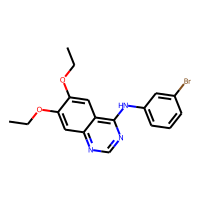
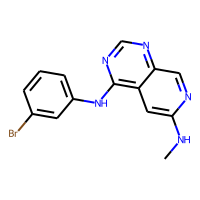
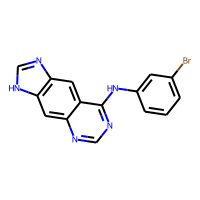

In [2]:
from rdkit.Chem import PandasTools

PandasTools.AddMoleculeColumnToFrame(compounds_df, "smiles", "mol")
compounds_df.head()

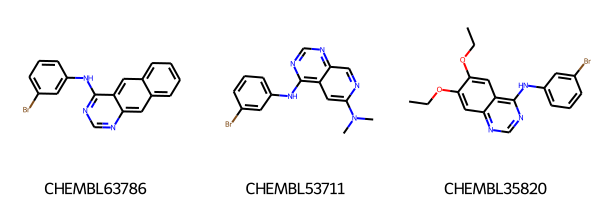

In [3]:
from rdkit import Chem

Chem.Draw.MolsToGridImage(
    list(compounds_df.head(3).mol),
    legends=list(compounds_df.head(3).molecule_chembl_id),
)

## 2. Filter for PAINS from RDKit Catalog

We can filter for PAINS directly using RDKit as follows.

In [4]:
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

# initialize the filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

/home/avcopan/conda/envs/cadd-env/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [5]:
from tqdm.auto import tqdm

# search for PAINS
matches = []
clean = []
for index, row in tqdm(compounds_df.iterrows(), total=compounds_df.shape[0]):
    mol = Chem.MolFromSmiles(row.smiles)
    match = catalog.GetFirstMatch(mol)
    if match is not None:
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": mol,
                "pains": match.GetDescription().capitalize(),
            }
        )
    else:
        clean.append(index)

matches = pd.DataFrame(matches)
compounds_df = compounds_df.loc[clean]

  0%|          | 0/4929 [00:00<?, ?it/s]

In [6]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(compounds_df)}")


Number of compounds with PAINS: 436
Number of compounds without PAINS: 4493


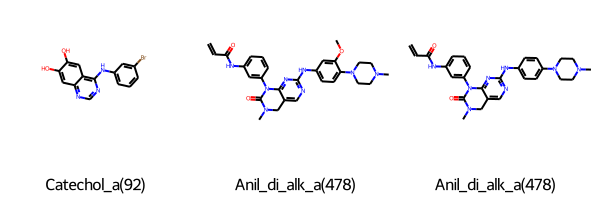

In [7]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

## 3. Filter for PAINS Manually

In [8]:
import os

data_path = os.path.join(os.getcwd(), "data")
file_path = os.path.join(data_path, "unwanted_substructures.csv")

uwss_df = pd.read_csv(file_path, sep="\s+")
uwss_df.head()

,name,smarts
0,>2EsterGroups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]"
1,2-haloPyridine,"n1c([F,Cl,Br,I])cccc1"
2,acidHalide,"C(=O)[Cl,Br,I,F]"
3,acyclic-C=C-O,C=[C!r]O
4,acylCyanide,N#CC(=O)


In [9]:
uwss_df["mol"] = uwss_df.smarts.apply(Chem.MolFromSmarts)
print(f"Number of unwanted substructures: {len(uwss_df)}")

Number of unwanted substructures: 104


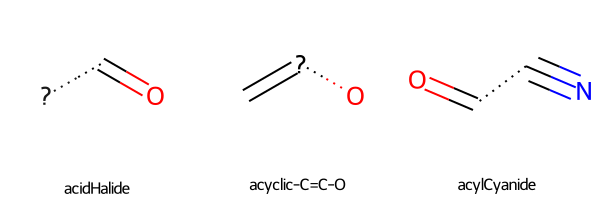

In [10]:
Chem.Draw.MolsToGridImage(
    mols=uwss_df.mol.tolist()[2:5],
    legends=uwss_df.name.tolist()[2:5],
)

In [11]:
matches = []
clean = []
for index, row in tqdm(compounds_df.iterrows(), total=compounds_df.shape[0]):
    mol = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, sub in uwss_df.iterrows():
        if mol.HasSubstructMatch(sub.mol):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "mol": mol,
                    "substructure": sub.mol,
                    "substructure_name": sub.name,
                }
            )
            match=True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
compounds_df = compounds_df.loc[clean]

  0%|          | 0/4493 [00:00<?, ?it/s]

In [12]:
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(compounds_df)}")

Number of found unwanted substructure: 3471
Number of compounds without unwanted substructure: 2194


## 4. Highlight PAINS Substructures

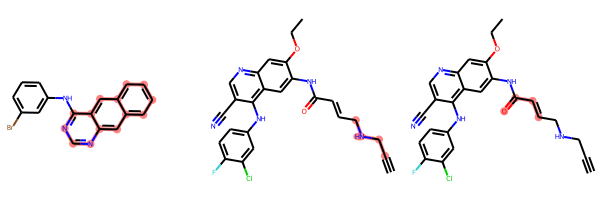

In [14]:
to_highlight = [
    row.mol.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).mol),
    highlightAtomLists=to_highlight,
    #legends=list(matches.head(3).substructure_name),
)